# Introduction

We did our project on the Arxiv dataset, which is a dataset containg data on over 1 million reserach papers published over the last 20 years. 
Going to a school which boasts about its interdisciplinary education such as Penn, we were intersted in examining how different disciplines were actually related in the world of academia. To that effect, we decided to construct a graph of different research domains (categories), where an edge represents the same author writing in both those categories. We ran PageRank on this graph to examine its topology and see which categories/research domains were most connected to other domains. 
We also played around with the data a little bit and examined things like which category had the most number of authors (on avergage), most common categories, etc. 
Finally, for further analysis, we decided to see if the language of an abstract indicates anything about what category a paper might be in. Do mathematicians use very different language than say, an economist? We tried to answer this question by training a Naive Bayes model on the abtracts to predict the category, and evaluating its accuracy.

# Imports

In [2]:
!pip3 install boto3

In [3]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [4]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [5]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 47 not upgraded.
Need to get 43.4 MB of archives.
After this 

In [6]:
import pandas as pd
import pyspark as spark
from pyspark.sql import SQLContext

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('545-Final-Project').getOrCreate()

In [7]:
%load_ext sparkmagic.magics

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#misc
import gc
import time
import warnings


#graph section
import networkx as nx
#import heapq  # for getting top n number of things from list,dict
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [9]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


# Data Wrangling

## Loading and formatting the data

Here, we load the Arxiv data set from an s3 bucket, and load it into spark.

In [10]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('arxivsaurabh').download_file('arxiv.json', 'arxiv.json')

In [11]:
data_sdf = spark.read.format('json').option('header', 'false').load('/content/arxiv.json')
data_sdf.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|            abstract|             authors|      authors_parsed|       categories|            comments|                 doi|       id|         journal-ref|             license|           report-no|         submitter|               title|update_date|            versions|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|C. Bal\'azs, E. L...|[[Balázs, C., ], ...|           hep-ph|37 pages, 15 figu...|10.1103/PhysRevD....|0704.0001|Phys.Rev.D76:0130...|                null|    ANL-HEP

We next drop columns which are not necessary, and have high insances of null values, and then drop all null rows from the table.

In [12]:
data_sdf = data_sdf.drop('license', 'report-no', 'authors', 'comments', 'doi', 'journal-ref')
data_sdf = data_sdf.dropna()
data_sdf.show()
print(data_sdf.count())

+--------------------+--------------------+-----------------+---------+------------------+--------------------+-----------+--------------------+
|            abstract|      authors_parsed|       categories|       id|         submitter|               title|update_date|            versions|
+--------------------+--------------------+-----------------+---------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|[[Balázs, C., ], ...|           hep-ph|0704.0001|    Pavel Nadolsky|Calculation of pr...| 2008-11-26|[[Mon, 2 Apr 2007...|
|  We describe a n...|[[Streinu, Ileana...|    math.CO cs.CG|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|  The evolution o...|  [[Pan, Hongjun, ]]|   physics.gen-ph|0704.0003|       Hongjun Pan|The evolution of ...| 2008-01-13|[[Sun, 1 Apr 2007...|
|  We show that a ...| [[Callan, David, ]]|          math.CO|0704.0004|      David Callan|A determinant of ...| 2007-05-23|[[Sat, 

We mainly plan on using the columns: abstract, authors parsed, categories and titles. We can see we have around 1.8 million data points.


---

## Parsing and reformatting the category column

We next define two functions: \\
**category_parser** -  Uses the dictionary *categories* to assign the Arxiv subcategories to broader groups (For example, assigning math.CO and math.FA to the broader group Math) \\
**splitter** - Simply parses the original categories into a list to allow iteration later on.

In [13]:
categories = {
    'cs.': 'CS',
    'econ.': 'Economics',
    'eess.': 'Electric and Systems Engineering',
    'math.': 'Math',
    'astro-ph': 'Astrophysics',
    'hep-': 'High-energy Physics',
    'cond-mat.': 'Condensed Matter Physics',
    'gr-qc': 'General Relativity and Cosmo',
    'math-ph': 'Mathematical Physics',
    'nlin.': 'Nonlinear Sciences',
    'nucl-': 'Nuclear Physics',
    'physics.': 'General Physics',
    'quant-ph': 'Quantum Physics',
    'q-bio.': 'Quantitative Bio',
    'q-fin.': 'Quantitative Finance',
    'stat.': 'Statistics'
}
def category_parser(cats):
  list_of_cats = set()
  for j in categories:
    if j in cats:
      list_of_cats.add(categories[j])
  return list(list_of_cats)

def splitter(to_split):
  return to_split.split()

spark.udf.register('CATEGORY_PARSER', category_parser, ArrayType(StringType()))
spark.udf.register('SPLITTER', splitter, ArrayType(StringType()))

<function __main__.splitter>

We next register these two UDF's with spark, and run a query on the table which creates the columns cats_parsed and cats_split by running the two functions on the category column. We then drop the category column, keeping only the new columns we added.

In [14]:
data_sdf.createOrReplaceTempView('data_sdf')
query = '''SELECT CATEGORY_PARSER(categories) as cats_parsed, SPLITTER(categories) as cats_split, *
          FROM data_sdf'''
data_sdf_new = spark.sql(query).drop('categories')
data_sdf_new.show()

+--------------------+-------------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|         cats_parsed|         cats_split|            abstract|      authors_parsed|       id|         submitter|               title|update_date|            versions|
+--------------------+-------------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|[High-energy Phys...|           [hep-ph]|  A fully differe...|[[Balázs, C., ], ...|0704.0001|    Pavel Nadolsky|Calculation of pr...| 2008-11-26|[[Mon, 2 Apr 2007...|
|          [Math, CS]|   [math.CO, cs.CG]|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|[CS, General Phys...|   [physics.gen-ph]|  The evolution o...|  [[Pan, Hongjun, ]]|0704.0003|       Hongjun Pan|The evolution of ...| 2008-01-13|[[Sun, 1 Apr 2

## Visualizing the data.

We first begin by exploding cats_parsed. We want to run a groupby operation to count the number of papers in each category. 

In [15]:
data_sdf_new.withColumn("cats_parsed", F.explode(data_sdf_new.cats_parsed)).show()
cats_parsed_sdf = data_sdf_new.withColumn("cats_parsed", F.explode(data_sdf_new.cats_parsed))
cats_parsed_sdf.createOrReplaceTempView('cats_counter')

cats_parsed_sdf = spark.sql('''
SELECT cats_parsed AS Category, COUNT(cats_parsed) as count 
FROM cats_counter 
GROUP BY cats_parsed
ORDER BY count DESC''')

cats_parsed_sdf.show()


+--------------------+-------------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|         cats_parsed|         cats_split|            abstract|      authors_parsed|       id|         submitter|               title|update_date|            versions|
+--------------------+-------------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
| High-energy Physics|           [hep-ph]|  A fully differe...|[[Balázs, C., ], ...|0704.0001|    Pavel Nadolsky|Calculation of pr...| 2008-11-26|[[Mon, 2 Apr 2007...|
|                Math|   [math.CO, cs.CG]|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|                  CS|   [math.CO, cs.CG]|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 

We can see CS and Math top the list as the most common categories, and economics comes out as the least common.


---

We next repeat this same process on cats_split. We explode the column and then groupby to count the number of occurrences of each sub-category. This will give us more info on which specific sub-topics are most common in the Arxiv database.

In [16]:
data_sdf_new.withColumn("cats_split", F.explode(data_sdf_new.cats_split)).show()
categories_sdf = data_sdf_new.withColumn("cats_split", F.explode(data_sdf_new.cats_split))
categories_sdf.createOrReplaceTempView('cats_split')

cats_split_sdf = spark.sql('''
SELECT cats_split AS Category, COUNT(cats_split) as count 
FROM cats_split
GROUP BY cats_split
ORDER BY count DESC
''')


+--------------------+-----------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|         cats_parsed|       cats_split|            abstract|      authors_parsed|       id|         submitter|               title|update_date|            versions|
+--------------------+-----------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|[High-energy Phys...|           hep-ph|  A fully differe...|[[Balázs, C., ], ...|0704.0001|    Pavel Nadolsky|Calculation of pr...| 2008-11-26|[[Mon, 2 Apr 2007...|
|          [Math, CS]|          math.CO|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|          [Math, CS]|            cs.CG|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|[CS

In [17]:
cats_split_sdf.createOrReplaceTempView('cats_split')
cats_split_sdf = spark.sql('''
SELECT *
FROM cats_split
where count > 175 and not category='comp-gas' and not category='chem-ph' and not category='mtrl-th' 
and not category='funct-an' and not category='adap-org' and not category='patt-sol' and not category='dg-ga'
and not category='cmp-lg' and not category='alg-geom' and not category='solv-int' and not category='q-bio'
and not category='q-alg' ''')
cats_split_sdf.show()

+------------------+------+
|          Category| count|
+------------------+------+
|            hep-ph|148505|
|            hep-th|136186|
|          quant-ph|107897|
|          astro-ph|103604|
|             gr-qc| 83822|
| cond-mat.mes-hall| 70872|
|             cs.LG| 70001|
| cond-mat.mtrl-sci| 67589|
|           math.MP| 63413|
|           math-ph| 63413|
|cond-mat.stat-mech| 60088|
|   cond-mat.str-el| 58498|
|       astro-ph.CO| 52751|
|             cs.CV| 48908|
|           math.CO| 47439|
|           nucl-th| 47357|
|           stat.ML| 46467|
|       astro-ph.SR| 45082|
|       astro-ph.GA| 44245|
|           math.AP| 43426|
+------------------+------+
only showing top 20 rows



After dropping mis-formatted categories (those not listed on the Arxiv site) such as *comp-gas* and *chem-ph*, we again return the subcategories in order of most occurrences. We see now, that the most common subcategories are high energy physics, quantum physics, and astrophysics, while math and CS subcategories have less occurrences. \\

\\

Finally, we print out the count of our table below, and see that there exist 158 unique subcategories with at least 1 occurrence .

In [18]:
print(cats_split_sdf.count())

158


### Plotting the data

Here we plot the number of occurrences of each general category using pandas and matplotlib. 

In [19]:
cats_split_pd = cats_split_sdf.toPandas()
cats_parsed_pd = cats_parsed_sdf.toPandas()

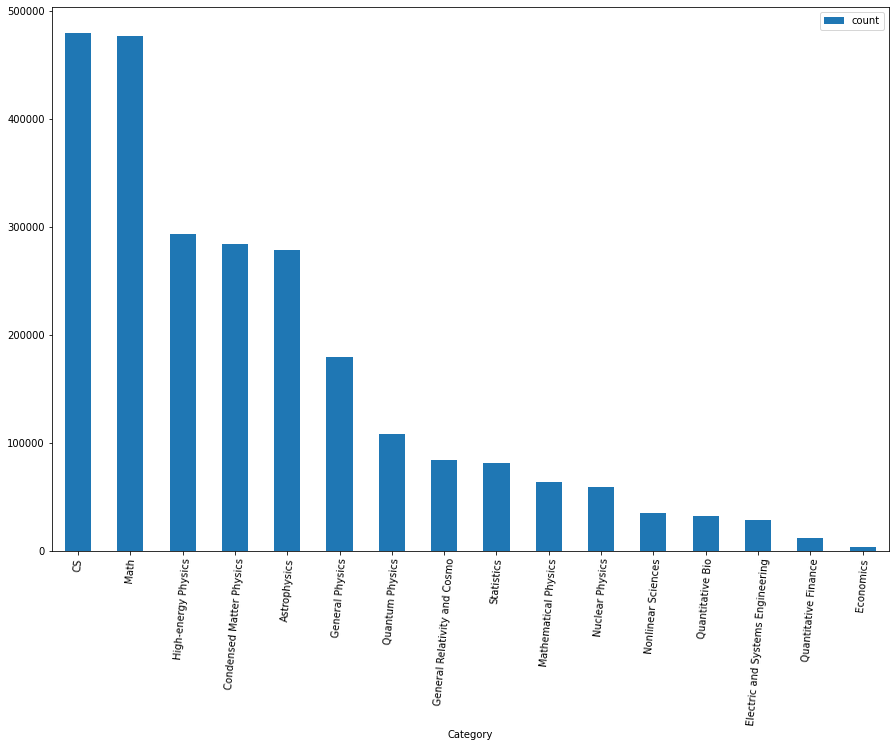

In [20]:
ax = cats_parsed_pd.plot.bar(x='Category', y='count', rot=85, figsize=(15,10))

Here we plot the number of occurrences of the more granular categories using pandas and matplotlib.

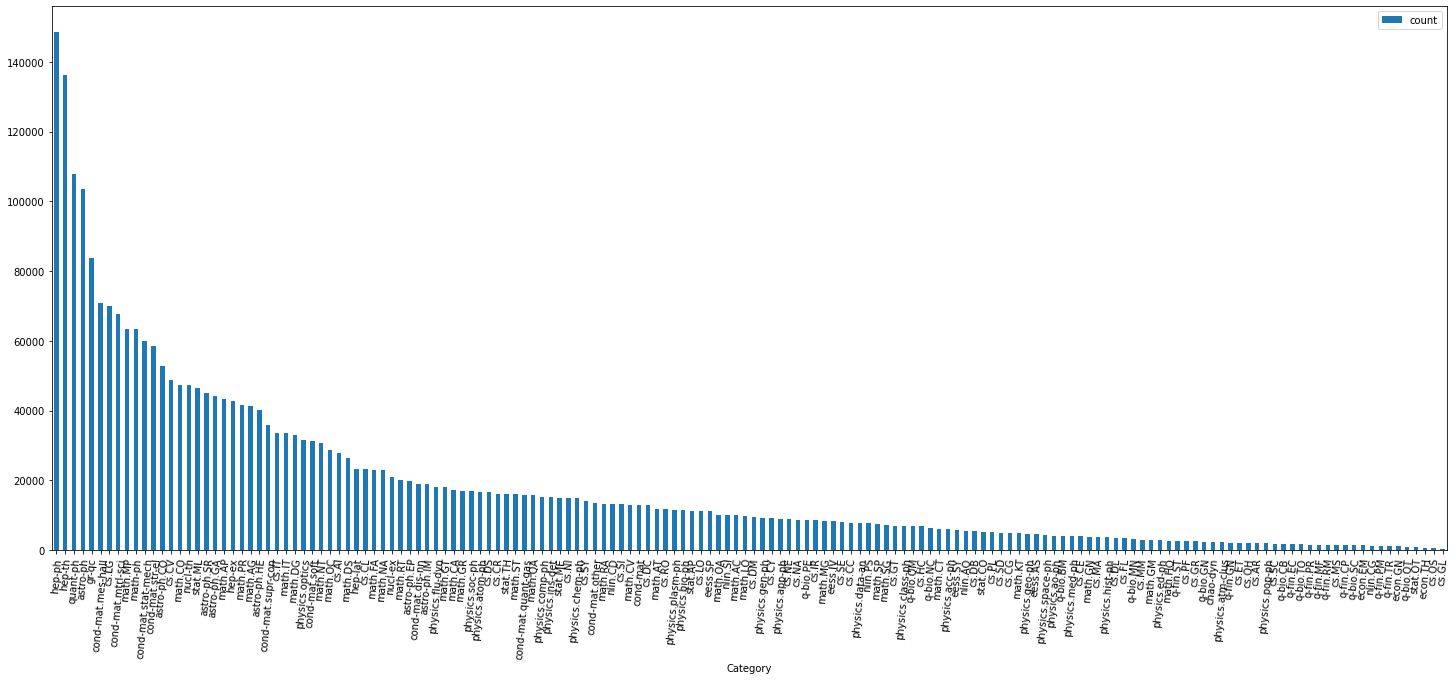

In [21]:
ax = cats_split_pd.plot.bar(x='Category', y='count', rot=85, figsize=(25,10))

**Unsurprisingly, we see that these are both heavy-tailed distributions**

In [22]:
def len_list(l):
  return len(l)
spark.udf.register('LEN_LIST', len_list, IntegerType())

<function __main__.len_list>

In [23]:
num_authors_sdf = spark.sql('''SELECT LEN_LIST(authors_parsed) as num_authors FROM data_sdf WHERE LEN_LIST(authors_parsed) > 39''')
num_authors_df = num_authors_sdf.toPandas()

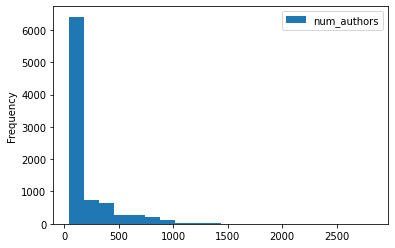

In [24]:
num_authors_df.plot.hist(bins=20)

In [25]:
num_authors_sdf = spark.sql('''SELECT LEN_LIST(authors_parsed) as num_authors FROM data_sdf WHERE LEN_LIST(authors_parsed) < 40''')
num_authors_df = num_authors_sdf.toPandas()

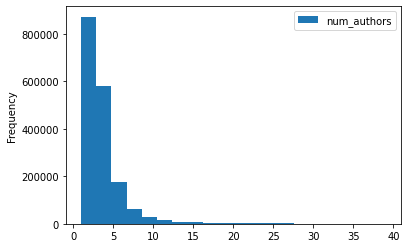

In [26]:
num_authors_df.plot.hist(bins=20)

These histograms represent the frequency of the number of authors per paper. This needed to be broken into two histograms, one for papers with greater than or equal to 40 authors (the first histogram) and one for papers with fewer than 40 authors (the second histogram). This needed to be done because there are a very large number of papers with relatively few authors, and a small number of papers with many authors. 

In [27]:
data_sdf_new.createOrReplaceTempView('df_new')
spark.sql("SELECT EXPLODE(cats_parsed) as cat, LEN_LIST(authors_parsed) as num_auth FROM df_new").createOrReplaceTempView('num_per_cat')
auth_per_cat_df = spark.sql('SELECT cat as Category, AVG(num_auth) as AvgNumAuthors FROM num_per_cat GROUP BY cat').toPandas()

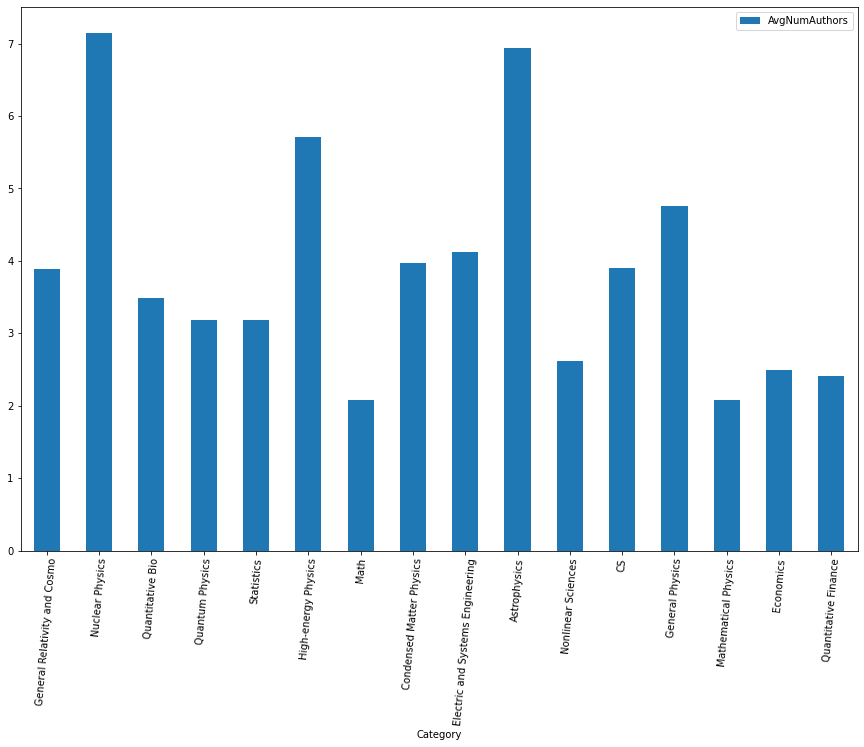

In [28]:
ax = auth_per_cat_df.plot.bar(x='Category', y='AvgNumAuthors', rot=85, figsize=(15,10))

This bar plot represents the average number of authors for a paper in a specific category. Interestingly, nuclear physics has on average the most authors per paper.

## Creating the graph for PageRank

For our graph, we want the categories to behave as vertices, and authors as edges. Thus, we will start with categories_sdf, where our vertices(cats_split) are already exploded.

In [29]:
categories_sdf.show()

+--------------------+-----------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|         cats_parsed|       cats_split|            abstract|      authors_parsed|       id|         submitter|               title|update_date|            versions|
+--------------------+-----------------+--------------------+--------------------+---------+------------------+--------------------+-----------+--------------------+
|[High-energy Phys...|           hep-ph|  A fully differe...|[[Balázs, C., ], ...|0704.0001|    Pavel Nadolsky|Calculation of pr...| 2008-11-26|[[Mon, 2 Apr 2007...|
|          [Math, CS]|          math.CO|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|          [Math, CS]|            cs.CG|  We describe a n...|[[Streinu, Ileana...|0704.0002|      Louis Theran|Sparsity-certifyi...| 2008-12-13|[[Sat, 31 Mar 200...|
|[CS

We next drop columns except for authors and categories. In our query, we again drop all misformatted categories, and then explode authors. This gives us a table the contains every relationship between an author and a category in our the dataset. In other words, every edge/vertex relationship which will be in our graph.

In [30]:
categories_sdf.createOrReplaceTempView('categories_sdf')
authors_sdf = spark.sql('''
SELECT authors_parsed as authors, cats_split as categories
FROM categories_sdf
where not cats_split='comp-gas' and not cats_split='chem-ph' and not cats_split='mtrl-th' 
and not cats_split='funct-an' and not cats_split='adap-org' and not cats_split='patt-sol' and not cats_split='dg-ga'
and not cats_split='cmp-lg' and not cats_split='alg-geom' and not cats_split='solv-int' and not cats_split='q-bio'
and not cats_split='q-alg' and not cats_split='bayes-an' and not cats_split='ao-sci' and not cats_split='plasm-ph'
and not cats_split='acc-phys' and not cats_split='atom-ph' and not cats_split='supr-con' ''')

authors_sdf = authors_sdf.withColumn("authors", F.explode(authors_sdf.authors))
authors_sdf.show()

+--------------------+-----------------+
|             authors|       categories|
+--------------------+-----------------+
|      [Balázs, C., ]|           hep-ph|
|   [Berger, E. L., ]|           hep-ph|
| [Nadolsky, P. M., ]|           hep-ph|
|    [Yuan, C. -P., ]|           hep-ph|
| [Streinu, Ileana, ]|          math.CO|
|   [Theran, Louis, ]|          math.CO|
| [Streinu, Ileana, ]|            cs.CG|
|   [Theran, Louis, ]|            cs.CG|
|    [Pan, Hongjun, ]|   physics.gen-ph|
|   [Callan, David, ]|          math.CO|
|[Abu-Shammala, Wa...|          math.CA|
|[Torchinsky, Albe...|          math.CA|
|[Abu-Shammala, Wa...|          math.FA|
|[Torchinsky, Albe...|          math.FA|
|     [Pong, Y. H., ]|cond-mat.mes-hall|
|      [Law, C. K., ]|cond-mat.mes-hall|
|[Corichi, Alejand...|            gr-qc|
|[Vukasinac, Tatja...|            gr-qc|
| [Zapata, Jose A., ]|            gr-qc|
|[Swift, Damian C., ]|cond-mat.mtrl-sci|
+--------------------+-----------------+
only showing top

We run a groupby operation on authors. For every author in the table, this gives us a list of every category they have written in, or has a paper related to. 

In [31]:
author_category_sdf = authors_sdf.groupBy("authors").agg(F.collect_set("categories")).withColumnRenamed("collect_set(categories)", "categories")
author_category_sdf.show()

+--------------------+--------------------+
|             authors|          categories|
+--------------------+--------------------+
|    [A., M., , Tony]|       [astro-ph.IM]|
|[A2 Collaboration...|[nucl-ex, hep-ex,...|
|[AMOYAL, Guillaum...|[physics.med-ph, ...|
| [Aarrestad, Thea, ]|[physics.comp-ph,...|
|     [Aavikko, R., ]| [cond-mat.mtrl-sci]|
|   [Abal, Gonzalo, ]|          [quant-ph]|
|[Abate, Alexandra...|       [astro-ph.CO]|
|[Abbas, Ibrahim A...|[math.DS, astro-p...|
|  [Abbas, Mahmoud, ]|[eess.IV, q-bio.Q...|
|      [Abbot, Tim, ]|[astro-ph.GA, ast...|
|[Abbrescia, Marce...|   [physics.ins-det]|
|[Abbring, Jaap H., ]|[econ.GN, q-fin.E...|
|[Abdesselem, A. B...|           [math.DG]|
|[Abdolmaleki, Rez...|           [math.AC]|
|   [Abdou, Sherif, ]|      [cs.CL, cs.CV]|
|     [Abdurrouf, , ]|       [astro-ph.GA]|
|[Abel-Tibérini, L...|[astro-ph.IM, ast...|
|  [Abenojar, Eric, ]|[physics.app-ph, ...|
|[Aberdein, Andrew, ]|  [math.HO, math.LO]|
|[Abeysekara, A. U...|       [as

We next want to make sure that every category list forms a mini complete graph, meaning each category is adjacent to all other categories in that list. Towards this end, we define another udf, **make_tuples**, which for every category list, returns a list of all possible tuple combinations of that list, except for a category to itself. 

These tuples will form the basis of our graph, because they represent the edge between two vertices(categories), which is why we wanted to remove self-edges. Thus, the list of all of the individual tuples in the graph will form an edge list.

In [32]:
x = [1,2,3]
def make_tuples(cats):

  if (len(cats) ==1):
    return None

  y = []

  for a in cats:
    for b in cats:
	    if a != b:
	  	  y.append([a, b])
  
  return y

spark.udf.register('make_pairs', make_tuples, ArrayType(ArrayType(StringType())))

<function __main__.make_tuples>

In [33]:
author_category_sdf.createOrReplaceTempView('graph_sdf')
query = '''SELECT make_pairs(categories) as edges
          FROM graph_sdf'''
graph_sdf = spark.sql(query)
graph_sdf.show()

+--------------------+
|               edges|
+--------------------+
|                null|
|[[nucl-ex, hep-ex...|
|[[physics.med-ph,...|
|[[physics.comp-ph...|
|                null|
|                null|
|                null|
|[[math.DS, astro-...|
|[[eess.IV, q-bio....|
|[[astro-ph.GA, as...|
|                null|
|[[econ.GN, q-fin....|
|                null|
|                null|
|[[cs.CL, cs.CV], ...|
|                null|
|[[astro-ph.IM, as...|
|[[physics.app-ph,...|
|[[math.HO, math.L...|
|                null|
+--------------------+
only showing top 20 rows



After applying our udf, we select only the edges column. We see many rows are null, which represent the authors who only ever wrote in one category, and thus formed no edges. Thus, we dropna, and explode the edge row to have a complete list of all the edges in the graph.

In [34]:
graph_sdf = graph_sdf.dropna()

In [35]:
edges_sdf = graph_sdf.withColumn("edges", F.explode(graph_sdf.edges))
edges_sdf.show()

+--------------------+
|               edges|
+--------------------+
|   [nucl-ex, hep-ex]|
|  [nucl-ex, nucl-th]|
|   [hep-ex, nucl-ex]|
|   [hep-ex, nucl-th]|
|  [nucl-th, nucl-ex]|
|   [nucl-th, hep-ex]|
|[physics.med-ph, ...|
|[physics.ins-det,...|
|[physics.comp-ph,...|
|[physics.comp-ph,...|
|[physics.comp-ph,...|
|[physics.comp-ph,...|
|[physics.comp-ph,...|
|[eess.IV, physics...|
|   [eess.IV, hep-ex]|
|  [eess.IV, eess.SP]|
|[eess.IV, physics...|
|    [eess.IV, cs.LG]|
|[hep-ex, physics....|
|   [hep-ex, eess.IV]|
+--------------------+
only showing top 20 rows



We know many edges will be repeated (meaning multiple authors have written in both categories). Thus, we perform a groupby on the unique edges. The new column, *count*, will represent the weight of each edge, meaning the more occurences of each edge, the heavier it is weighted.

In [36]:
edges_sdf.createOrReplaceTempView('edges_sdf')
query = '''SELECT edges, COUNT(edges) as weight
          FROM edges_sdf 
          GROUP BY edges
          ORDER BY weight DESC'''

edges_weighted_sdf = spark.sql(query)

In [37]:
edges_weighted_sdf.show()
print(edges_weighted_sdf.count())

+--------------------+------+
|               edges|weight|
+--------------------+------+
|    [stat.ML, cs.LG]| 62885|
|    [cs.LG, stat.ML]| 62885|
|    [hep-ex, hep-ph]| 47894|
|    [hep-ph, hep-ex]| 47894|
|[cond-mat.mes-hal...| 47082|
|[cond-mat.mtrl-sc...| 47082|
|[physics.ins-det,...| 44735|
|[hep-ex, physics....| 44735|
|  [math.MP, math-ph]| 43910|
|  [math-ph, math.MP]| 43910|
|[astro-ph.GA, ast...| 38535|
|[astro-ph.CO, ast...| 38535|
|      [cs.LG, cs.CV]| 37380|
|      [cs.CV, cs.LG]| 37380|
|[astro-ph.IM, ast...| 35056|
|[astro-ph.HE, ast...| 35056|
|[astro-ph.CO, ast...| 32489|
|[astro-ph.IM, ast...| 32489|
|[astro-ph.SR, ast...| 31979|
|[astro-ph.GA, ast...| 31979|
+--------------------+------+
only showing top 20 rows

24790


Here we have our final edge list, consisting of 24790 edges and their corresponding weights. We can see each edge has a corresponding back-edge of the same weight, which is correct since our graph is undirected. Thus, our graph has 12395 unique edges! 

*(This is almost 158 choose 2 meaning our graph is nearly a complete graph. Thats a lot of interdisciplinary study!)* 

### Creating the adjacency matrix

In [38]:
import itertools as itools

edge_list_df = edges_weighted_sdf.toPandas()

We convert the edge list to an adjacency matrix as a numpy array, giving each category an id between 0 and 157.

In [39]:
list_cats = list(set(itools.chain.from_iterable(edge_list_df.edges)))
cats_to_ids = {}
ids_to_cats = {}
for i in range(len(list_cats)):
  cats_to_ids[list_cats[i]] = i
  ids_to_cats[i] = list_cats[i]
print(cats_to_ids)
print(ids_to_cats)

{'stat.AP': 0, 'hep-ph': 1, 'math.RT': 2, 'math.KT': 3, 'math.NT': 4, 'q-fin.EC': 5, 'cs.DL': 6, 'nlin.CG': 7, 'cond-mat.stat-mech': 8, 'astro-ph.HE': 9, 'cs.GT': 10, 'physics.atom-ph': 11, 'math.AC': 12, 'math.MG': 13, 'cs.AR': 14, 'stat.TH': 15, 'cs.SY': 16, 'cond-mat.dis-nn': 17, 'stat.ML': 18, 'physics.space-ph': 19, 'math.CV': 20, 'cs.CY': 21, 'physics.plasm-ph': 22, 'physics.flu-dyn': 23, 'physics.class-ph': 24, 'eess.AS': 25, 'cs.CC': 26, 'physics.atm-clus': 27, 'physics.gen-ph': 28, 'gr-qc': 29, 'q-fin.ST': 30, 'q-bio.MN': 31, 'quant-ph': 32, 'nlin.AO': 33, 'math.CT': 34, 'eess.SP': 35, 'physics.data-an': 36, 'q-bio.SC': 37, 'math.FA': 38, 'math.HO': 39, 'cs.AI': 40, 'math.GT': 41, 'math.ST': 42, 'cs.NA': 43, 'q-fin.RM': 44, 'physics.soc-ph': 45, 'cs.GR': 46, 'q-bio.TO': 47, 'astro-ph.IM': 48, 'nucl-th': 49, 'physics.med-ph': 50, 'cs.MS': 51, 'eess.SY': 52, 'math.SG': 53, 'cs.CV': 54, 'math.IT': 55, 'cs.NE': 56, 'stat.OT': 57, 'physics.ao-ph': 58, 'cond-mat.mtrl-sci': 59, 'math

In [40]:
adj_mat = np.zeros((158, 158))
for index, row in edge_list_df.iterrows():
  r = cats_to_ids[row['edges'][0]]
  c = cats_to_ids[row['edges'][1]]
  adj_mat[r][c] = row['weight']
print(adj_mat)

[[0.000e+00 6.160e+02 1.470e+02 ... 1.120e+02 1.417e+03 2.500e+01]
 [6.160e+02 0.000e+00 3.830e+02 ... 5.470e+02 6.400e+02 1.200e+01]
 [1.470e+02 3.830e+02 0.000e+00 ... 2.200e+01 1.560e+02 1.000e+00]
 ...
 [1.120e+02 5.470e+02 2.200e+01 ... 0.000e+00 2.800e+01 4.600e+01]
 [1.417e+03 6.400e+02 1.560e+02 ... 2.800e+01 0.000e+00 2.300e+01]
 [2.500e+01 1.200e+01 1.000e+00 ... 4.600e+01 2.300e+01 0.000e+00]]


Here, we can see our completed adjacency matrix which we will be using for PageRank. We see all edges and back-edges having the same weight. 

Lastly we divide each column by the sum of its total weight, to normalize all weights to 1

In [41]:
#Divide by column sums to make all columns sum to 1
adj_mat_normed = adj_mat/adj_mat.sum(axis=0, keepdims=1)

# PAGERANK!

We run the PageRank algorithm with a damping factor of 0.85 for 75 iterations. Using the adjacency matrix for the graph, running the PageRank algorithm boils down to a series matrix multiplications. To measure the convergence we look at the sum of the changes in the PageRank values for all nodes in the graph from one iteration to the next.

In [42]:
damping = 0.85
p_weights = np.ones((158, 1))
iters = 75
# Total difference in all pagerank values from one iteration to the next
iter_difference = []
A = damping * adj_mat_normed + (1 - damping)/158
for i in range(iters):
  p_weights_new = A @ p_weights
  diff = np.sum(np.absolute(p_weights_new - p_weights))
  iter_difference.append(diff)
  p_weights = p_weights_new

We find that the categories with the highest PageRank values are Machine Learning, Materials Science, Quantum Physics, and High Energy Physics -  Phenomenology. It’s interesting to consider what it really means for a category to have a high PageRank value in this context. One way to interpret the PageRank of a category in our graph is as how interdisciplinary a category is in the corpus of all papers, or in other words papers more often include high PageRank categories as an additional category aside from the main category under which we may first classify the paper.

In [43]:
p_weights_df = pd.DataFrame(p_weights, columns=['PageRank']).reset_index()
p_weights_df['Category'] = p_weights_df['index'].map(ids_to_cats)
p_weights_df = p_weights_df.sort_values(by=['PageRank'], ascending=False).drop('index', axis=1)
p_weights_df 

,PageRank,Category
116,4.404241,cs.LG
18,3.356277,stat.ML
59,3.070152,cond-mat.mtrl-sci
32,3.024731,quant-ph
1,2.844766,hep-ph
...,...,...
57,0.248931,stat.OT
67,0.240909,math.GM
89,0.219451,cs.OS
122,0.217597,econ.TH


Here we plot the sum difference in PageRank values from iteration to iteration and see that it declines quite sharply.

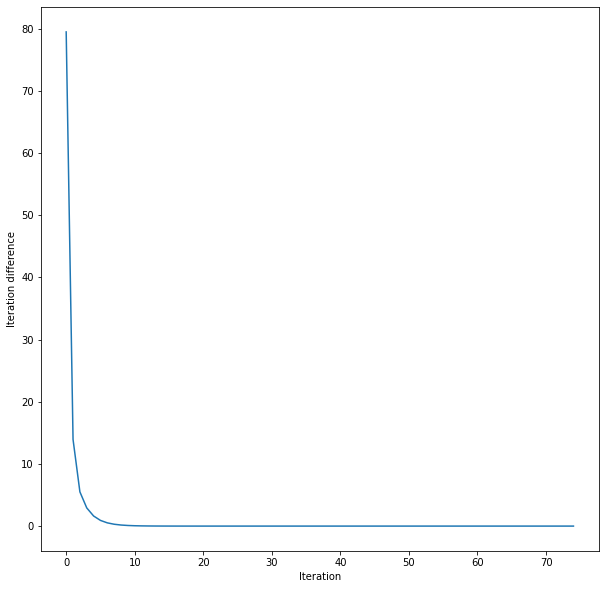

In [44]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(iter_difference)
plt.xlabel('Iteration')
plt.ylabel('Iteration difference')
plt.show()

To gain a clearer picture of the PageRank algorithm in action, here we plot the log of the difference in PageRank values from iteration to iteration and see that it declines almost exactly linearly.

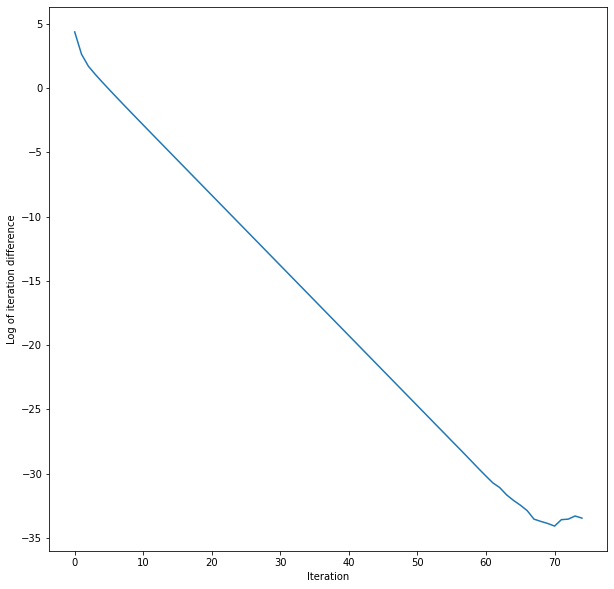

In [45]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(np.log(iter_difference))
plt.xlabel('Iteration')
plt.ylabel('Log of iteration difference')
plt.show()

# Category Prediction and Modeling

## Data formatting

Here we create an sdf with just the abstract and the category, since that’s all we need for our classifier. We limit our data to 100,000 rows since fitting with more than that gets very costly. 


In [46]:
cats_abstract_sdf = data_sdf_new.select('cats_parsed', 'abstract').withColumn('primary_category', data_sdf_new.cats_parsed[0])
cats_abstract_sdf.createOrReplaceTempView('cats_abstract_sdf')
query = '''SELECT abstract, primary_category
          FROM cats_abstract_sdf
          Limit 100000'''
cats_abstract_sdf = spark.sql(query)
cats_abstract_sdf.show()


+--------------------+--------------------+
|            abstract|    primary_category|
+--------------------+--------------------+
|  A fully differe...| High-energy Physics|
|  We describe a n...|                Math|
|  The evolution o...|                  CS|
|  We show that a ...|                Math|
|  In this paper w...|                Math|
|  We study the tw...|Condensed Matter ...|
|  A rather non-st...|General Relativit...|
|  A general formu...|Condensed Matter ...|
|  We discuss the ...|        Astrophysics|
|  Partial cubes a...|                Math|
|  In this paper w...|                Math|
|  Recently, Bruin...|                Math|
|  Serre obtained ...|                Math|
|  In this article...|                Math|
|  The pure spinor...| High-energy Physics|
|  In this work, w...| High-energy Physics|
|  Results from sp...|        Astrophysics|
|  We give a presc...| High-energy Physics|
|  In this note we...|                Math|
|  The shape of th...| High-ener



We use nltk’s tokenizer to break the abstracts into bags of words. We clean the abstracts by removing stop words as well as non-alphabetic characters. 


In [47]:
import nltk 
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
regex = re.compile('[^a-zA-Z]')


def tokenize(abs):
  
  abs = abs.lower()
  x =  nltk.word_tokenize(regex.sub(' ', abs))
  

  x2 = []

  for i in x:
    if i not in stopwords:
      x2.append(i)
  return x2
  
cats_abstract_sdf.createOrReplaceTempView('abs_cats')
spark.udf.register('TOKENIZE', tokenize, ArrayType(StringType()))
token_abs_sdf = spark.sql('select TOKENIZE(abstract) as abstract_tokenized, primary_category from abs_cats')
token_abs_sdf.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
+--------------------+--------------------+
|  abstract_tokenized|    primary_category|
+--------------------+--------------------+
|[fully, different...| High-energy Physics|
|[describe, new, a...|                Math|
|[evolution, earth...|                  CS|
|[show, determinan...|                Math|
|[paper, show, com...|                Math|
|[study, two, part...|Condensed Matter ...|
|[rather, non, sta...|General Relativit...|
|[general, formula...|Condensed Matter ...|
|[discuss, results...|        Astrophysics|
|[partial, cubes, ...|                Math|
|[paper, present, ...|                Math|
|[recently, bruini...|                Math|
|[serre, obtained,...|                Math|
|[article, discuss...|                Math|
|[pure, spinor, fo...| High-energy 

## Naive Bayes Modeling

Here we start building our pipeline for our classifier. Since we already tokenized and cleaned the bag of words, we just have two steps: vectorized the input and output. For the input we use a wordVectorizer library and for the output we simply map each category to a number from 0 to n-1, where n is the number of categories. 


In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, StringIndexer

count_vectors = CountVectorizer(inputCol='abstract_tokenized', outputCol='features', vocabSize=50000, minDF=5)
label_indexer = StringIndexer(inputCol='primary_category', outputCol='label')
pipeline=Pipeline(stages=[count_vectors, label_indexer])

pipelineFit = pipeline.fit(token_abs_sdf)
dataset = pipelineFit.transform(token_abs_sdf)
dataset.show(5)

+--------------------+-------------------+--------------------+-----+
|  abstract_tokenized|   primary_category|            features|label|
+--------------------+-------------------+--------------------+-----+
|[fully, different...|High-energy Physics|(25653,[8,13,17,2...|  3.0|
|[describe, new, a...|               Math|(25653,[4,7,12,15...|  0.0|
|[evolution, earth...|                 CS|(25653,[0,3,6,7,1...|  4.0|
|[show, determinan...|               Math|(25653,[5,94,143,...|  0.0|
|[paper, show, com...|               Math|(25653,[2,5,10,22...|  0.0|
+--------------------+-------------------+--------------------+-----+
only showing top 5 rows



Now we’re ready to split the training and test data and run our Naive Bayes model on it. 


In [49]:
train_sdf, test_sdf = dataset.randomSplit([0.8, 0.2])
print('Train size: ' + str(train_sdf.count()))

Train size: 80058


In [50]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1)
model = nb.fit(train_sdf)
predictions = model.transform(test_sdf)
predictions.select("abstract_tokenized","primary_category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+----------------+------------------------------+-----+----------+
|            abstract_tokenized|primary_category|                   probability|label|prediction|
+------------------------------+----------------+------------------------------+-----+----------+
|[paper, demostrates, method...|            Math|[1.0,2.2171669760528384E-21...|  0.0|       0.0|
|[conjecture, strong, proper...|            Math|[1.0,1.0899830214535293E-21...|  0.0|       0.0|
|[paper, compute, alexander,...|            Math|[1.0,6.770734272705641E-22,...|  0.0|       0.0|
|[let, compact, set, right, ...|            Math|[1.0,2.3446847401967455E-22...|  0.0|       0.0|
|[let, gamma, g, z, g, denot...|            Math|[1.0,1.5035743785796725E-22...|  0.0|       0.0|
|[rips, complexes, covers, u...|            Math|[1.0,4.7919758626871664E-23...|  0.0|       0.0|
|[construct, coarse, moduli,...|            Math|[1.0,7.071128935419833E-24,...|  0.0|       0.0|
|[let, closed, disk,


Finally we evaluate its accuracy. 80% is not bad! Especially when you consider the obscureness of the task, how 16 unique categories were included, and things like computer science and statistics papers using a lot of the same language, it seems like our model was very successful.

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8056824941417833

# Challenges we encountered



One of the key challenges we faced was the wrangling of the data. We found uploading and storing our data on Google Drive was not a viable option. Storing the data on Drive made it much more difficult for us to work on our project individually in pieces. At one point the data even became corrupted in Google Drive, which set us back considerably. In the end, we were able to resolve this issue by storing our data in an S3 bucket. This made importing the data fast and reliable each time we wanted to start a work session.

Another key challenge we faced was long runtimes for a lot of the analysis and modeling that we wanted to do. This was probably due largely to the size of our dataset. Since our data consisted of over 1.7 million entries, running expensive operations, like groupbys and model training became very time-consuming. To get around this we sampled smaller portions of our dataset for certain parts of the project, particularly the modeling. Assuming the samples we take are reasonably representative of the entire dataset, we believe we should have attained approximately the same results, as we would have if we had run our computations on the entire dataset.

Lastly, we also ran into some complications using Google Colab. Namely, Google Colab does not do a great job at supporting concurrent editing and running of a notebook. This meant that it was challenging to distribute the work that needed to be done on the project. Overall, we just ended up doing a lot of group coding, working together to accomplish different tasks in our notebook. We could have likely just used some other technology to concurrently do different pieces of work for our project, but in retrospect we found that lots of group coding always kept us on the same page.

# Where to go from here

This project was fun and our analysis was pretty cool, but it’s by no means complete. For example, we could have spun up some EC2 instances and trained over the whole dataset to get a better model for predicting categories. We also could have done some more graph analysis, with building something like a graph of authors, where an edge represents them working together. Running PageRank on this might tell us who the most influential authors are. 


We also found another dataset which had data on citations for different research papers. If we had more time we could have used the citations dataset to train a model and see which properties of a research paper are successful, which ‘success’ being defined as something like the number of times a paper is cited. We could do something like predicting the number of citations based on the abstract, authors, category etc. Another thing we could do with the citations dataset is run PageRank based on a citation graph, which would be a cool way to see how influential a certain paper is.